In [1]:
#Instal
!pip install yfinance --upgrade --no-cache-dir
# virtualenv -p python3 virtualenvironment
# source virtualenvironment/bin/activate
!pip install ta --upgrade --no-cache-dir
!pip install pandas_ta --upgrade --no-cache-dir
#imports
import time
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as web
import matplotlib.pyplot as plt

from math import floor
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from ta.volatility import bollinger_mavg, KeltnerChannel

yf.pdr_override()

In [2]:
#Define functions

#GET YAHOO DATA
def get_data(ticker):
    date = DATE
    
    all_data = []
    aux_date = 0
    length_test = 0
    
    while length_test < LOOP_MAX + CORR_WINDOW:
        final_date = date + timedelta(days=(LOOP_MAX + SHIFT_DAYS + CORR_WINDOW + aux_date))
        all_data = web.get_data_yahoo(ticker, date, final_date)
        aux_date = aux_date + 20
        length_test = len(all_data)
        
    return all_data

def convert_data(all_data, ticker):
    
    names = []
    table = []
    
    for i in range(0, LOOP_MAX, SHIFT_DAYS) :
        data = all_data[i:CORR_WINDOW + i]
        date = data.index[0]
        ticker_name = ticker + ' ' + date.strftime('%Y/%m/%d')
        names.append(ticker_name)
        data['Ticker'] = ticker_name
        table.append(data)    
        
    return [names, table]

#CREATE DATAFRAMES
def create_dfs(datas_to_df):
    dfs = []
    for data_to_df in datas_to_df :
        name, data = data_to_df
        df = pd.DataFrame()
        df = pd.concat(data)
        df = df.reset_index()
        df = df.pivot(columns='Ticker',values='Close')
        dfs.append(df)
    return dfs

#PIVOT FUNCTIONS
def pivot_df(df_pivot, data, names): 
    for i in range(floor(LOOP_MAX/SHIFT_DAYS)) :
        column_name = names[i]
        values = data[column_name].values
        values = values[~np.isnan(values)]
        values = pd.Series(values)
        df_pivot.insert(len(df_pivot.columns), column_name, values)
        
    return df_pivot

def pivot_all_dfs(dfs, datas):
    dfs_pivoted = []
    names = []
    loop_times = len(dfs) - 1
    
    for j in range(loop_times):
        for i in range(j, loop_times):
            name_to_first = datas[j][0]
            names_to_second = datas[i + 1][0]
            names.append([name_to_first, names_to_second])
            
            df_pivoted = pd.DataFrame()
            df_pivoted = pivot_df(df_pivoted, dfs[j], name_to_first)
            df_pivoted = pivot_df(df_pivoted, dfs[i + 1], names_to_second)
            dfs_pivoted.append(df_pivoted)
        
    return [dfs_pivoted, names]

#CORRELATION FUNCTIONS
def get_corr_df(df_pivot, nameRow, nameColumn):
    #Using corr function to get correlation between actives
    corr_df = df_pivot.corr(method='pearson')
    #reset symbol as index (rather than 0-X)
    corr_df.head().reset_index()
    corr_df = corr_df.rename_axis(None, axis=0)
    corr_df = corr_df.drop(nameRow, axis=1)
    corr_df = corr_df.drop(nameColumn, axis=0)
    
    return corr_df

def get_all_corr_dfs(dfs, names):
    dfs_corr = []
    for i in range(len(dfs)):
        corr_df = get_corr_df(dfs[i], names[i][0], names[i][1])
        dfs_corr.append(corr_df)
    
    return dfs_corr

#INDICATOR FUNCTIONS
def get_indicators(df):
    values = df.values
    means_df = pd.DataFrame()
    deviations_df = pd.DataFrame()
    columns_name = []
    rang = floor(NUMBER_OF_TESTE/SHIFT_DAYS)
    for i in range(rang):
        means = []
        deviations = []
        row_name = df.index[i] + " - " + df.index[i + CORR_WINDOW].split(' ')[1] 
        for j in range(rang):
            if i == 0:
                column_name = df.columns[j] + " - " + df.columns[j + CORR_WINDOW].split(' ')[1] 
                columns_name.append(column_name)
            ax = []
            for k in range(CORR_WINDOW):
                value = values[i+k][j+k]
                ax.append(value)

            mean = np.average(ax)
            means.append(mean)

            deviation = np.std(ax)
            deviations.append(deviation)
            
        aux_df = pd.DataFrame([means], columns=columns_name, index=[row_name])
        means_df = pd.concat([means_df, aux_df])
        aux_df = pd.DataFrame([deviations], columns = columns_name, index=[row_name])
        deviations_df = pd.concat([deviations_df, aux_df])
        
    return [means_df, deviations_df]

def get_df_plot(dfs_corr):
    means, deviations = get_indicators(dfs_corr)
    
    rang = len(means.index) - SHIFT_DAYS
    values_means = means.values
    values_deviations = deviations.values
    values = []
    columns = [1,2,3,4]
    
    for i in range(rang):
        value = []
        value_mean = values_means[i][i + SHIFT_DAYS]
        value_deviation = values_deviations[i][i + SHIFT_DAYS]
        value.append(value_mean)
        value.append(value_deviation)
        
        value_mean = values_means[i + SHIFT_DAYS][i]
        value_deviation = values_deviations[i + SHIFT_DAYS][i]
        value.append(value_mean)
        value.append(value_deviation)
        
        values.append(value)
    columns = get_columns_name(means)    
    final_df = pd.DataFrame(values, columns=columns)
    return final_df

def get_columns_name(df):
    names = []
    
    for ind in ["Means", "Deviations"]:
        ticker = df.columns[0].split(" ")[0]
        
        index = df.index[0].split(" ")
        start_date = index[1]

        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = index[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    for ind in ["Means", "Deviations"]:
        index = df.index[0].split(" ")
        start_date = index[1]
        ticker = index[0]
        last_index = df.index[len(df.index) - (SHIFT_DAYS + 1)].split(" ") 
        end_date = last_index[1]
        
        name = ind + " - "
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date + "\n"

        index = df.index[1].split(" ")
        last_index = df.index[-1].split(" ")
        start_date = index[1]
        end_date = last_index[1]
        ticker = df.columns[0].split(" ")[0]
        
        name = name + ticker + " start at "
        name = name + start_date + " unitl "
        name = name + end_date
        names.append(name)
        
    return names

def get_price_df(df_p, names):
    df = pd.DataFrame()
    dates = []
    length = len(df_p[names[0]].columns)
    
    column = []    
    ticker = names[0][0].split(" ")[0]
    for i in range(length):
        dates.append(names[0][i].split(" ")[1])
        column.append(df_p[names[0]].values[0][i])
    
    df.insert(len(df.columns), ticker, column)
    
    column = []
    ticker = names[1][0].split(" ")[0]
    for i in range(length):
        column.append(df_p[names[1]].values[0][i])
            
    df.insert(len(df.columns), ticker, column) 
    
    mavg = get_mavg(df)
    df = df.join(mavg)
    df.insert(0, "Date", dates)
    return df

def get_mavg(df):
    mavg_df = pd.DataFrame()
    
    for column in df.columns:
        mavg_aux = bollinger_mavg(df[column], window=MAVG_WINDOW, fillna=True)
        mavg_df.insert(len(mavg_df.columns),"moving average of " + column, mavg_aux)
        
    return mavg_df

#Keltner Channel
def get_KC(datas):    
    high = []
    close = []
    low = []
    lenght = len(datas[1])
    data = datas[1]

    for i in range(lenght):
        high.append(data[i]["High"][0])
        close.append(data[i]["Close"][0])
        low.append(data[i]["Low"][0])

    df_o = pd.DataFrame({"High": high, "Close": close, "Low": low})
    
    KC = KeltnerChannel(high=df_o["High"], close=df_o["Close"], low=df_o["Low"], multiplier=MULTIPLIER, window=20, fillna=True)
    
    return KC

def get_all_stocks_KC(data):
    lenght = len(data)
    dfs = []
    for i in range(lenght):
        ticker1 = tickers[i]
        df_kc1 = get_KC(all_datas[i])
        high1 = list(df_kc1.keltner_channel_hband())
        low1 = list(df_kc1.keltner_channel_lband())
        
        for j in range(i+1, lenght):
            ticker2 = tickers[j]
            df_kc2 = get_KC(all_datas[j])
            high2 = list(df_kc2.keltner_channel_hband())
            low2 = list(df_kc2.keltner_channel_lband())
            
            df_aux = pd.DataFrame({ticker1 + "-High": high1, ticker1 + "-Low": low1, 
                                   ticker2 + "-High": high2, ticker2 + "-Low": low2})
            dfs.append(df_aux)
            
    return dfs

In [27]:
#Constants
#Fazer mais simulações
SHIFT_DAYS = 1
CORR_WINDOW = 9 # 5 7 9
MAVG_WINDOW = 42 # 36 38 40
MULTIPLIER = 1 #1 2 3
ENTER_CORR = 0.7
NUMBER_OF_TESTE = 600

DATE = datetime(2012, 1, 1)

LOOP_MAX = NUMBER_OF_TESTE * 2

In [4]:
#Load data
all_datas = []
tickers = ['ENBR3.SA','VALE3.SA','ITUB3.SA','BBAS3.SA','BBSE3.SA', 'PSSA3.SA']

for ticker in tickers:
    data = get_data(ticker)
    all_datas.append(data)

C:\Users\turen\AppData\Local\Temp/ipykernel_9176/3544271363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Ticker'] = ticker_name


In [5]:
for i in range(len(tickers)):
    dfs = create_dfs(all_datas[i], tickers[i])

#Pivoting table to aggregate active price in a line of each date
dfs_pivoted, names = pivot_all_dfs(dfs, all_datas)

dfs_corr = get_all_corr_dfs(dfs_pivoted, names)

C:\Users\turen\AppData\Local\Temp/ipykernel_9176/2807483580.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  dfs_pivoted, names = pivot_all_dfs(dfs, all_datas)


In [ ]:
# for corr_window in [5,7,9]:
#     CORR_WINDOW = corr_window
    
#     for i in range(len(tickers)):
#         dfs = create_dfs(all_datas[i], tickers[i])
        
#     dfs_pivoted, names = pivot_all_dfs(dfs, all_datas)

#     dfs_corr = get_all_corr_dfs(dfs_pivoted, names)
    
#     for i in range(len(dfs_corr)):
#         aux_ind = get_df_plot(dfs_corr[i])
#         indicators_dfs.append(aux_ind)
        
#     for mavg_window in [36,38,40,42]:
#         MAVG_WINDOW = mavg_window
        
#         for i in range(len(dfs_corr)):
#             price_df = get_price_df(dfs_pivoted[i], names[i])
#             prices_dfs.append(price_df)
            
#         for multiplier in [1,2,3]:
#             MULTIPLIER = multiplier
            
#             dfs_kc = get_all_stocks_KC(all_datas)
            
#             for enter_corr in [0.66,0.68,0.7,0.72]:
#                 ENTER_CORR = enter_corr
                
#                 for i in range(len(dfs_corr)):
#                     equity_curve = pd.DataFrame(columns=['Date', 'Profit'])
                    
#                     equity_aux = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i])
#                     equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
                    
#                     equity_aux = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i])
#                     equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
                    
#                     equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
                    
#                     final_profit = list(equity_curve['Profit'].values)[-1]

In [6]:
# fig, corr_ax = plt.subplots()
indicators_dfs = []
prices_dfs = []

for i in range(len(dfs_corr)):
    aux_ind = get_df_plot(dfs_corr[i])
    indicators_dfs.append(aux_ind)
    
    price_df = get_price_df(dfs_pivoted[i], names[i])
    prices_dfs.append(price_df)

# for i in range(2): 
#     mean = final_df.columns[i * 2]
#     deviation = final_df.columns[(i * 2) + 1]
#     plt.fill_between(final_df.index, final_df[mean] - final_df[deviation], final_df[mean] + final_df[deviation], alpha=0.2)
#     final_df.plot(y=mean,figsize=(10,10), xlim=[0, len(final_df[mean]) - 1], ylim=[-1,1], grid=True, ax=corr_ax)

In [7]:
dfs_kc = get_all_stocks_KC(all_datas)

# fig, price_ax = plt.subplots()

# price_df.plot(figsize=(10,10), xlim=[0, len(price_df) - 1], grid=True, ax=price_ax)

In [43]:
def trade_comprado(corr_df, price_df, kcs_df):#Culva de equity
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
    lost_corr = ENTER_CORR - 0.1
    enter_corr = ENTER_CORR
    
    stop_lose = 0.06
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    stock_a = price_df.columns[1]
    stock_b = price_df.columns[2]
    stock_a_mavg = price_df.columns[3]
    stock_b_mavg = price_df.columns[4]
    
    stock_a_predicting_mean_corr = corr_df.columns[0]
    stock_a_predicting_desviation_corr = corr_df.columns[1]
    stock_b_predicting_mean_corr = corr_df.columns[2]
    stock_b_predicting_desviation_corr = corr_df.columns[3]
    
    stock_a_high_kc = kcs_df.columns[0]
    stock_a_low_kc = kcs_df.columns[1]
    stock_b_high_kc = kcs_df.columns[2]
    stock_b_low_kc = kcs_df.columns[3]
    
    file = open(path_comprado, "a+")
    
    for g in range(2):
        
        nmb_stock = 0
        nmb_orders = 0
        paid_stock = 0
        money = 1000
        sell_cause = ""
        bought = False
        
        title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
        file.write(title)
        
        for i in range(price_length):
            stock_price = price_df[stock_b][i]
            
            aux = floor(i / corr_relation)
            if aux >= corr_length:
                aux = corr_length - 1
                
            if bought:
                if stock_price > kcs_df[stock_b_high_kc][i]:
                    sell_cause = "Better than KC"
                    bought = False
                if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                    sell_cause = "{0} is low than mavg".format(stock_a)
                    bought = False
#                 if corr_df[stock_b_predicting_mean_corr][aux] < lost_corr:#testar sem este IF
#                     sell_cause = "Lost correlation"
#                     bought = False
#                 if stock_price <= paid_stock * (1 - stop_lose):
#                     sell_cause = "Stop, lost {0}%".format(stop_lose * 100)
#                     bought = False

                if not bought:
                    if(nmb_stock > 0):
                        profit = ((stock_price * nmb_stock) - (paid_stock * nmb_stock))
                        EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                        equity = equity.append(EC_aux)
                    money += stock_price * nmb_stock
                    nmb_stock = 0
                    file.write("selling in {0} - money: {1} - cause:{2}\n".format(dates[i], money, sell_cause))#stonk prices
                    nmb_orders += 1
            else:
                if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                    if stock_price < price_df[stock_b_mavg][i]:
                        if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                            bought = True
                            nmb_stock = floor(money/stock_price)
                            money = money%stock_price
                            paid_stock = stock_price
                            file.write("buying in {0} - money: {1}, stocks: {2}\n".format(dates[i], money, nmb_stock))
                            nmb_orders += 1
        file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
        
        stock_a = price_df.columns[2]
        stock_b = price_df.columns[1]
        stock_a_mavg = price_df.columns[4]
        stock_b_mavg = price_df.columns[3]
        
        stock_a_predicting_mean_corr = corr_df.columns[2]
        stock_a_predicting_desviation_corr = corr_df.columns[3]
        stock_b_predicting_mean_corr = corr_df.columns[0]
        stock_b_predicting_desviation_corr = corr_df.columns[1]
        
        stock_a_high_kc = kcs_df.columns[2]
        stock_a_low_kc = kcs_df.columns[3]
        stock_b_high_kc = kcs_df.columns[0]
        stock_b_low_kc = kcs_df.columns[1]
    
    file.close()
 
    return equity

def trade_vendido(corr_df, price_df, kcs_df):
    equity = pd.DataFrame(columns=['Date', 'Profit'])
    
    lost_corr = ENTER_CORR - 0.1
    enter_corr = ENTER_CORR
    
    stop_lose = 0.06
    
    price_length = len(price_df.index)
    corr_length = len(corr_df.index)
    corr_relation = floor(price_length / corr_length)
    
    date = price_df.columns[0]
    dates = price_df[date]
    
    stock_a = price_df.columns[1]
    stock_b = price_df.columns[2]
    stock_a_mavg = price_df.columns[3]
    stock_b_mavg = price_df.columns[4]
    
    stock_a_predicting_mean_corr = corr_df.columns[0]
    stock_a_predicting_desviation_corr = corr_df.columns[1]
    stock_b_predicting_mean_corr = corr_df.columns[2]
    stock_b_predicting_desviation_corr = corr_df.columns[3]
    
    stock_a_high_kc = kcs_df.columns[0]
    stock_a_low_kc = kcs_df.columns[1]
    stock_b_high_kc = kcs_df.columns[2]
    stock_b_low_kc = kcs_df.columns[3]
    
    file = open(path_vendido, "a+")
    
    for g in range(2):
        
        nmb_stock = 0
        nmb_orders = 0
        sold_stock = 0
        money = 1000
        purchase_cause = ""
        sold = True
        
        title = "Using {0} to predict {1}\n".format(stock_a, stock_b)
        file.write(title)
        
        for i in range(1, price_length):
            stock_price = price_df[stock_b][i]
            
            aux = floor(i / corr_relation)
            if aux >= corr_length:
                aux = corr_length - 1
            
            if sold:
                if stock_price < kcs_df[stock_b_low_kc][i]:
                    purchase_cause = "Lower than KC"
                    sold = False
                if price_df[stock_a][i] > price_df[stock_a_mavg][i]:
                    purchase_cause = "{0} is better than mavg".format(stock_a)
                    sold = False
#                 if corr_df[stock_b_predicting_mean_corr][aux] < lost_corr:#testar sem este IF
#                     purchase_cause = "Lost correlation"
#                     sold = False
#                 if stock_price >= sold_stock * (1 - stop_lose):
#                     purchase_cause = "Stop, lost {0}%".format(stop_lose * 100)
#                     sold = False

                if not sold:
                    nmb_stock = floor(money/stock_price)
                    money = money%stock_price
                    if(sold_stock != 0):
                        profit = ((sold_stock * nmb_stock) - (stock_price * nmb_stock))
                        EC_aux = pd.DataFrame([{"Date": dates[i], "Profit": profit}])
                        equity = equity.append(EC_aux)
                    file.write("Buying in {0} - money: {1},  stocks: {2} - cause:{3}\n".format(dates[i], money, nmb_stock, purchase_cause))
                    nmb_orders += 1
                
            else:
                if price_df[stock_a][i] < price_df[stock_a_mavg][i]:
                    if stock_price > price_df[stock_b_mavg][i]:
                        if corr_df[stock_b_predicting_mean_corr][aux] > enter_corr:
                            sold = True
                            money += stock_price * nmb_stock
                            nmb_stock = 0
                            sold_stock = stock_price
                            file.write("Selling in {0} - money: {1}\n".format(dates[i], money))
                            nmb_orders += 1
                            
        file.write("Money in final of tests {0} and Number of orders {1}\n\n".format(money, nmb_orders))
        
        stock_a = price_df.columns[2]
        stock_b = price_df.columns[1]
        stock_a_mavg = price_df.columns[4]
        stock_b_mavg = price_df.columns[3]
        
        stock_a_predicting_mean_corr = corr_df.columns[2]
        stock_a_predicting_desviation_corr = corr_df.columns[3]
        stock_b_predicting_mean_corr = corr_df.columns[0]
        stock_b_predicting_desviation_corr = corr_df.columns[1]
        
        stock_a_high_kc = kcs_df.columns[2]
        stock_a_low_kc = kcs_df.columns[3]
        stock_b_high_kc = kcs_df.columns[0]
        stock_b_low_kc = kcs_df.columns[1]
    
    file.close()
    return equity

In [9]:
#Testes

# equity_curve = pd.DataFrame(data=[{"Date": "2021/07/11", "Profit": -10},{"Date": "2022/05/12", "Profit": 50}, {"Date": "2020/06/11", "Profit": 20}],columns=['Date', 'Profit'])
# EC_aux = pd.DataFrame([{"Date": "2022/06/11", "Profit": -15}])
# equity_curve = pd.concat([equity_curve, EC_aux])
# equity_curve.sort_values(by='Date')
# equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
# equity_curve

<AxesSubplot:xlabel='Date'>

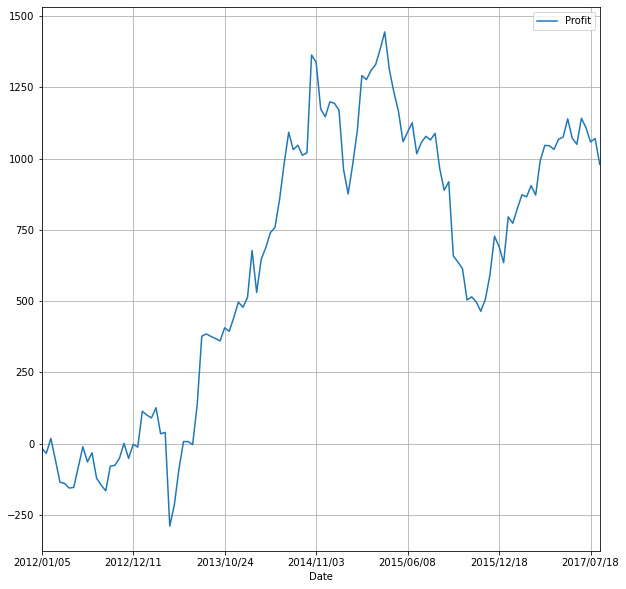

In [44]:
import os

path_comprado = "trade_comprado.txt"
path_vendido = "trade_vendido.txt"

if os.path.exists(path_comprado):
    os.remove(path_comprado)
if os.path.exists(path_vendido):
    os.remove(path_vendido)

equity_curve = pd.DataFrame(columns=['Date', 'Profit'])

for i in range(len(dfs_corr)):
    equity_aux = trade_comprado(indicators_dfs[i], prices_dfs[i], dfs_kc[i])
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    equity_aux = trade_vendido(indicators_dfs[i], prices_dfs[i], dfs_kc[i])
    equity_curve = pd.concat([equity_curve, equity_aux], ignore_index=True)
    
equity_curve = pd.DataFrame(equity_curve.groupby(['Date']).Profit.sum().cumsum())
equity_curve

fig, equity_ax = plt.subplots()

equity_curve.plot(figsize=(10,10), xlim=[0, len(equity_curve) - 1], grid=True, ax=equity_ax)